## Imports

In [1]:
from dataclasses import dataclass

import os
import math

import polars as pl
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

## Config

In [2]:
TRAIN_PATH = "/kaggle/input/hull-tactical-market-prediction/train.csv"
TEST_PATH = "/kaggle/input/hull-tactical-market-prediction/test.csv"

TARGET_COLUMN = "market_forward_excess_returns"

## Loading and Processing Data

In [32]:
# Load data
train = pd.read_csv(TRAIN_PATH)
exclude = ["date_id", 'forward_returns', 'risk_free_rate', 'market_forward_excess_returns']
train_cols = []

train = train.iloc[1006:,:]

for col in train.columns:
    nans = train[col].isna().sum()
    if nans == 0 and col not in exclude:
        train_cols.append(col)

# Columns to keep
print(f"train_cols: {train_cols}")

train_cols: ['D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'E10', 'E11', 'E12', 'E13', 'E14', 'E15', 'E16', 'E17', 'E18', 'E19', 'E2', 'E3', 'E4', 'E5', 'E6', 'E8', 'E9', 'I1', 'I2', 'I3', 'I4', 'I5', 'I6', 'I7', 'I8', 'I9', 'M10', 'M11', 'M12', 'M15', 'M16', 'M17', 'M18', 'M4', 'M7', 'M8', 'M9', 'P1', 'P10', 'P11', 'P12', 'P13', 'P2', 'P3', 'P4', 'P8', 'P9', 'S1', 'S10', 'S11', 'S2', 'S4', 'S6', 'S7', 'S9', 'V1', 'V11', 'V12', 'V2', 'V3', 'V4', 'V6', 'V8']


## Histograms of selected features

(8, 9)


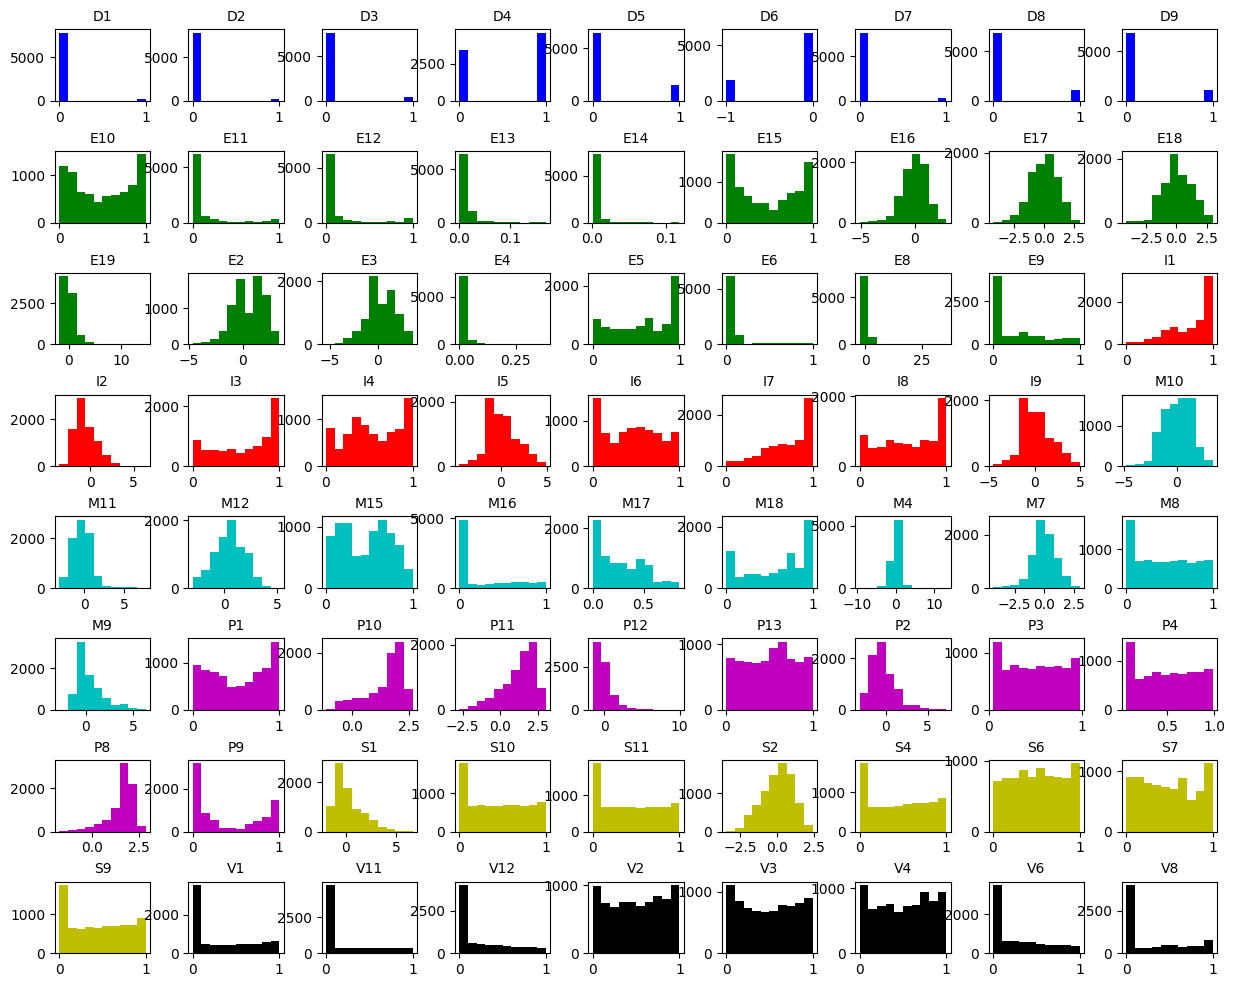

In [30]:
ax_rows = math.isqrt(len(train_cols))
ax_cols = (len(train_cols) + ax_rows-1) // ax_rows
fig, axs = plt.subplots(ax_rows, ax_cols, figsize=(15,12))
plt.subplots_adjust(wspace=0.4, hspace=0.7)


color_map = {
    'D': 'b',
    'E': 'g',
    'I': 'r',
    'M': 'c',
    'P': 'm',
    'S': 'y',
    'V': 'k'
}

# Plot data
for i,col in enumerate(train_cols):

    ro = i // ax_cols
    co = i % ax_cols
    
    axs[ro,co].hist(train.loc[:,col], color=color_map[col[0]])
    axs[ro,co].set_title(col, fontsize=10)
    # Set X-axis tick label size
    axs[ro,co].tick_params(axis='x', labelsize=10)
    
    # Set Y-axis tick label size
    axs[ro,co].tick_params(axis='y', labelsize=10)

print(axs.shape)

## Scatterplots

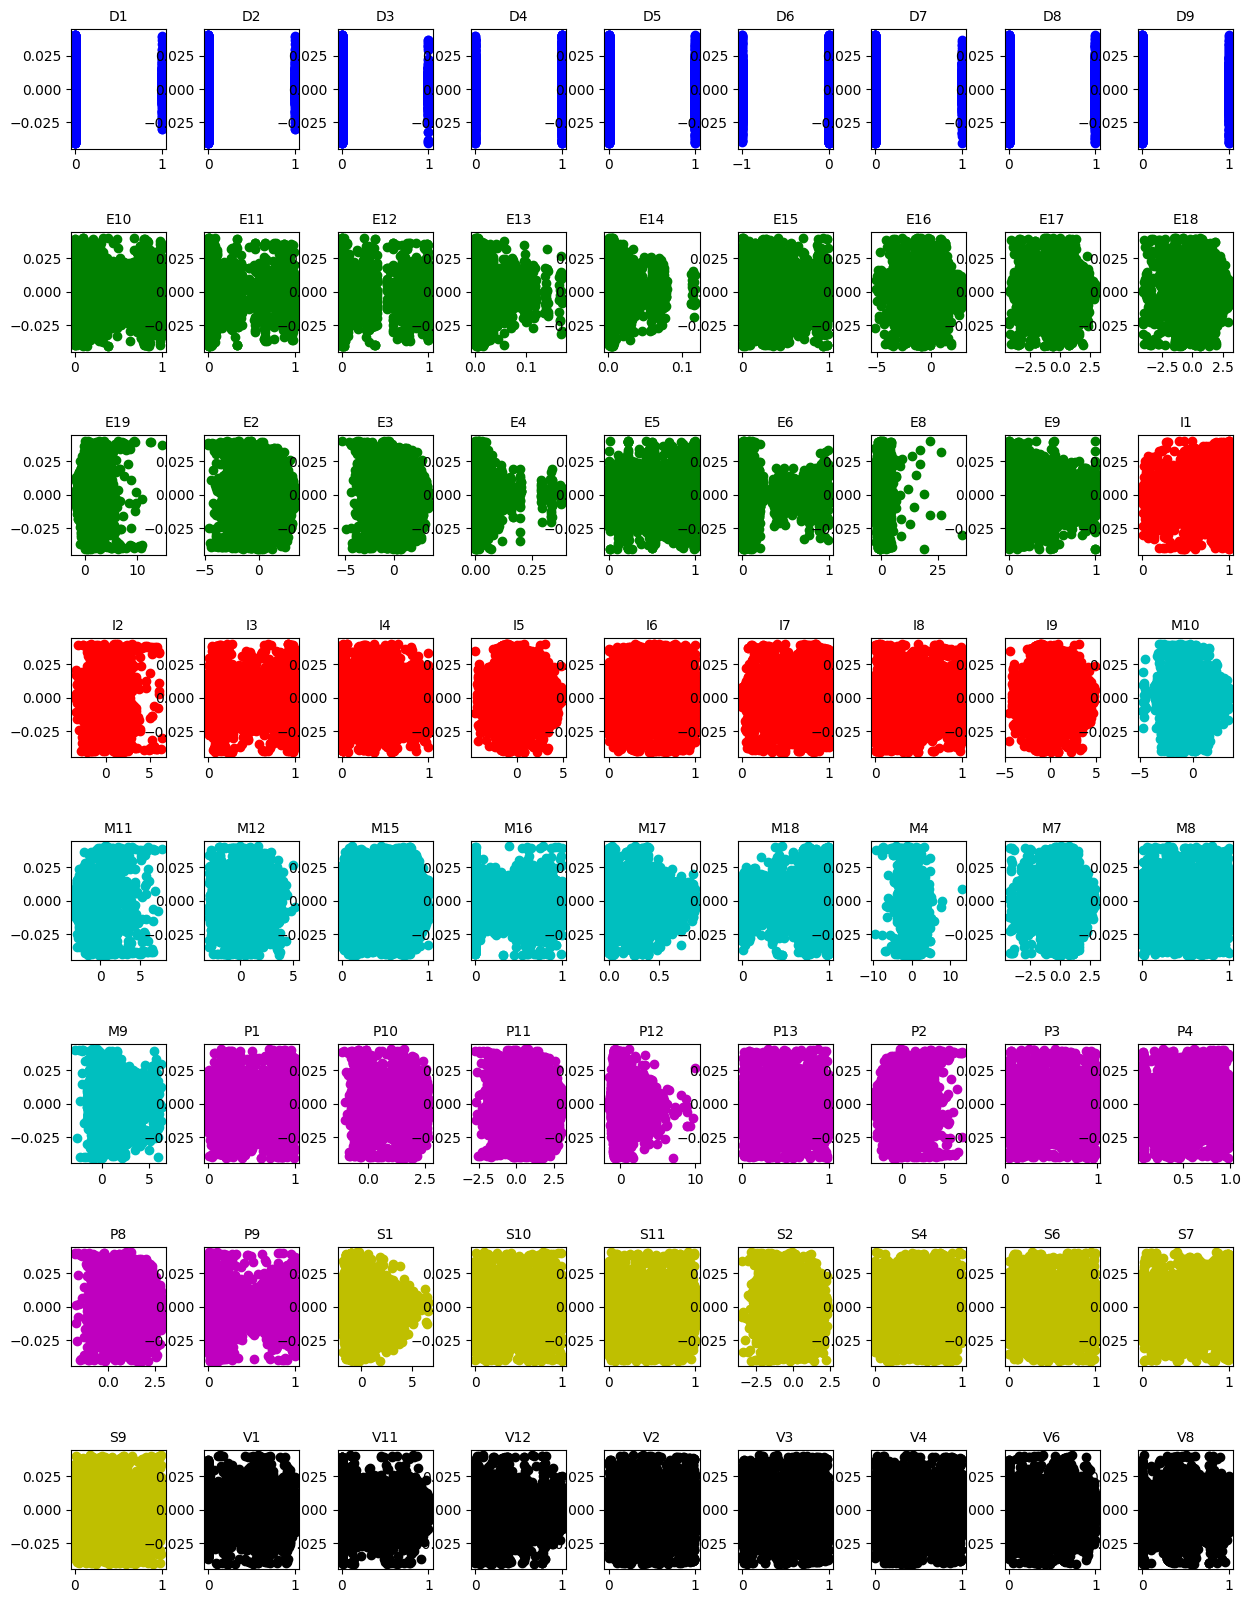

In [87]:
ax_rows = math.isqrt(len(train_cols))
ax_cols = (len(train_cols) + ax_rows-1) // ax_rows
fig, axs = plt.subplots(ax_rows, ax_cols, figsize=(15,20))
plt.subplots_adjust(wspace=0.4, hspace=0.7)

correlations = []

# Plot data
for i,col in enumerate(train_cols):

    ro = i // ax_cols
    co = i % ax_cols
    
    axs[ro,co].scatter(train.loc[:,col], train[TARGET_COLUMN], color=color_map[col[0]])
    axs[ro,co].set_title(col, fontsize=10)
    # Set X-axis tick label size
    axs[ro,co].tick_params(axis='x', labelsize=10)
    
    # Set Y-axis tick label size
    axs[ro,co].tick_params(axis='y', labelsize=10)

    corr = np.corrcoef(train.loc[:,col], train[TARGET_COLUMN])[0,1]
    correlations.append(corr)


In [91]:
print("Maximum and minimum correlations between the feature and the target")
max(correlations), min(correlations)

Maximum and minimum correlations between the feature and the target


(0.033840494800144755, -0.06659955380363183)

There does not seem to be any linear relationship between the features and the target. However, there may be some relationship between the variance of the target and some of the features (which may be due to the lowered proportion of data for some features at certain levels).

## Correlation matrix

In [41]:
train_selected = train.loc[:, train_cols]
train_selected.shape, np.array(train_selected).shape

((8015, 72), (8015, 72))

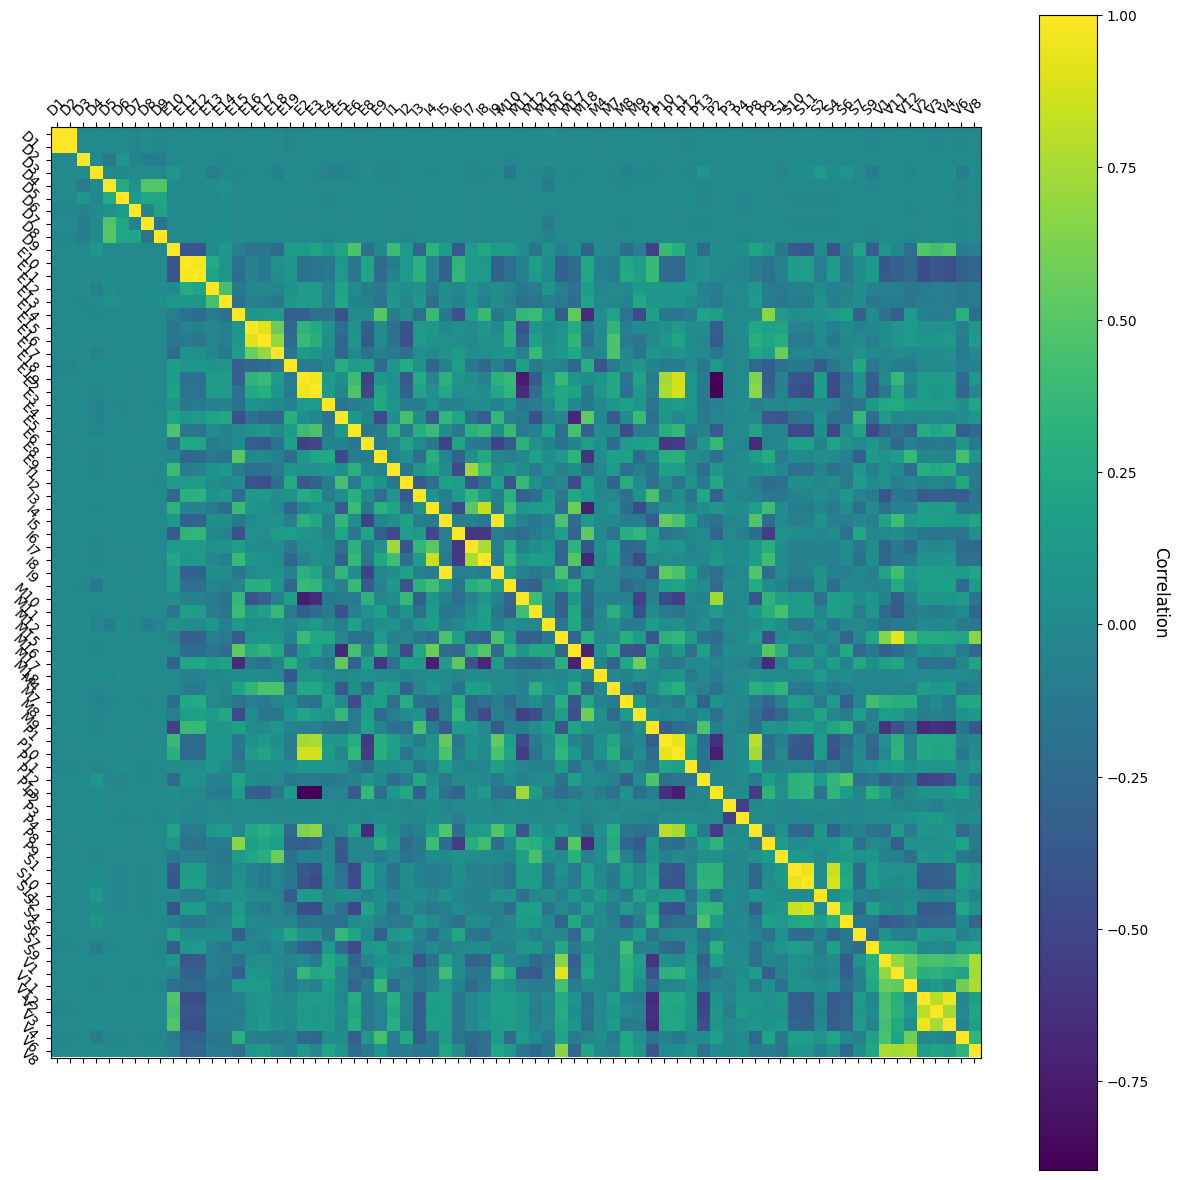

In [60]:

corr_matrix = np.corrcoef(train_selected.T)
rows,cols = corr_matrix.shape
fig, ax = plt.subplots(figsize=(15, 15))
im = ax.matshow(corr_matrix)
cbar = fig.colorbar(im, ax=ax, orientation='vertical')
cbar.set_label('Correlation', rotation=270, labelpad=15, fontsize=12)

ax.set_xticks(np.arange(0, cols, 1, dtype=int))
ax.set_xticklabels(train_cols, rotation=45, ha='center');
ax.set_yticks(np.arange(0, cols, 1, dtype=int))
ax.set_yticklabels(train_cols, rotation=-45, ha='right');

Notable observations:
- the V features are more correlated with each other than other groups
- the dummy features have little correlation with any other variable

## Target distribution

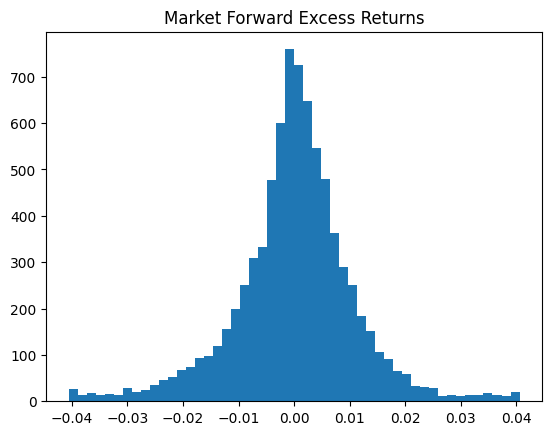

In [73]:
target = train[TARGET_COLUMN]
plt.hist(target, bins=50)
plt.title("Market Forward Excess Returns")
plt.show()

In [67]:
n = len(target)
mu = target.mean()
sigma = target.std()
one_sigma_prop = ((target - mu >= -sigma) & (target - mu < sigma)).sum() / n
two_sigma_prop = ((target - mu >= -2 * sigma) & (target - mu < 2 * sigma)).sum() / n
three_sigma_prop = ((target - mu >= -3 * sigma) & (target - mu < 3 * sigma)).sum() / n

print(f"mean: {target.mean():.4f} stddev: {target.std():.4f}")
print("\nProportion of data falling between 1, 2, 3 standard deviations:")
print(f"{one_sigma_prop:.4f}, {two_sigma_prop:.4f}, {three_sigma_prop:.4f}")

mean: 0.0001 stddev: 0.0108

Proportion of data falling between 1, 2, 3 standard deviations:
0.7631, 0.9384, 0.9800


Fitted generalized normal: beta=1.008, loc=0.000, scale=0.718


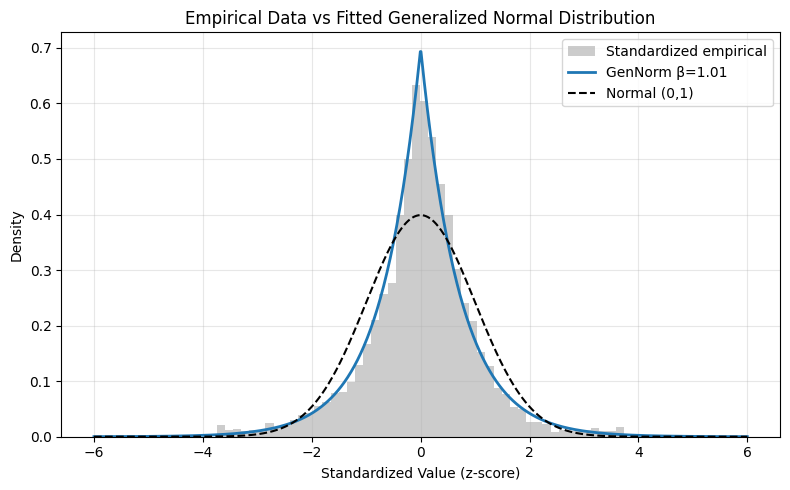

In [69]:
from scipy.stats import gennorm, norm

# Standardize data
z = (target - mu) / sigma

# Fit generalized normal
params = gennorm.fit(z)  # returns (beta, loc, scale)
beta, loc, scale = params
print(f"Fitted generalized normal: beta={beta:.3f}, loc={loc:.3f}, scale={scale:.3f}")

# x-range and PDFs
x = np.linspace(-6, 6, 1000)
pdf_fit = gennorm.pdf(x, *params)
pdf_norm = norm.pdf(x)

# Plot
plt.figure(figsize=(8,5))
plt.hist(z, bins=50, density=True, alpha=0.4, color='gray', label='Standardized empirical')
plt.plot(x, pdf_fit, label=f'GenNorm β={beta:.2f}', linewidth=2)
plt.plot(x, pdf_norm, 'k--', label='Normal (0,1)')
plt.xlabel("Standardized Value (z-score)")
plt.ylabel("Density")
plt.title("Empirical Data vs Fitted Generalized Normal Distribution")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

The distribution looks like a Laplace distribution, lets see how well it fits our data:

Laplace fit: loc=0.024, scale=0.710


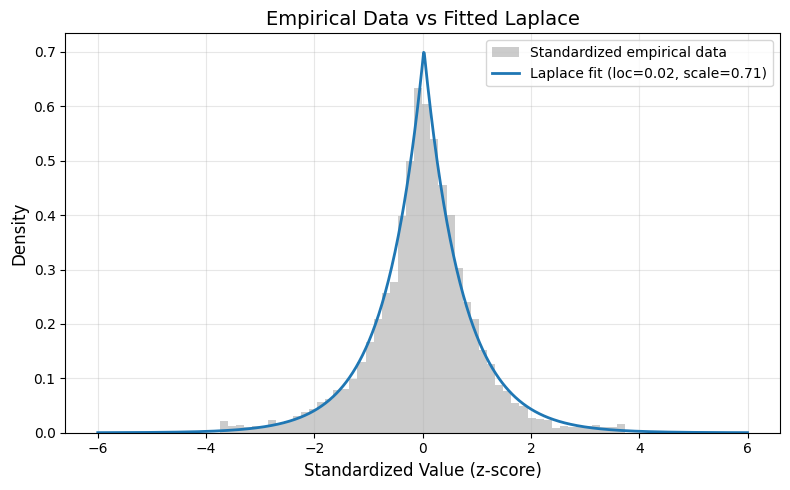

In [75]:
from scipy.stats import laplace

# Fit Laplace parameters (loc and scale)
loc, scale = laplace.fit(z)
print(f"Laplace fit: loc={loc:.3f}, scale={scale:.3f}")

# Define x-range and PDFs
x = np.linspace(-6, 6, 1000)
pdf_laplace = laplace.pdf(x, loc=loc, scale=scale)

# Plot
plt.figure(figsize=(8,5))
plt.hist(z, bins=50, density=True, alpha=0.4, color='gray', label='Standardized empirical data')
plt.plot(x, pdf_laplace, label=f'Laplace fit (loc={loc:.2f}, scale={scale:.2f})', linewidth=2)

# Labels and legend
plt.title("Empirical Data vs Fitted Laplace", fontsize=14)
plt.xlabel("Standardized Value (z-score)", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()